# Shadow Prices and Reduced Costs

In [1]:
import cobra.test
import numpy as np
import pandas as pd
from cobrapy_bigg_client import client
import matplotlib.pyplot as plt
import escher
from escher import Builder
pd.set_option('display.max_rows', 500)


In [2]:
model_orig = client.download_model('e_coli_core', save=False) # Loading the model to the simulation
model_orig.solver = 'glpk'

Set parameter Username
Academic license - for non-commercial use only - expires 2022-10-10


## Shadow Prices

Shadow prices are calculated with the model.optimize() method.

In [3]:
model = model_orig.copy()
solution = model.optimize()
solution.shadow_prices.round(5)

glc__D_e    -0.09166
gln__L_c    -0.07511
gln__L_e    -0.07002
glu__L_c    -0.07002
glu__L_e    -0.06875
glx_c       -0.01910
h2o_c       -0.00000
h2o_e        0.00000
h_c          0.00127
h_e          0.00000
icit_c      -0.07129
lac__D_c    -0.04201
lac__D_e    -0.04074
mal__L_c    -0.04838
mal__L_e    -0.04583
nad_c        0.00764
nadh_c       0.00000
nadp_c       0.00891
nadph_c      0.00000
nh4_c        0.00000
13dpg_c     -0.04711
nh4_e        0.00000
o2_c        -0.00000
2pg_c       -0.04201
o2_e         0.00000
3pg_c       -0.04201
oaa_c       -0.04201
pep_c       -0.04201
6pgc_c      -0.09166
pi_c        -0.00127
6pgl_c      -0.09039
pi_e         0.00000
ac_c        -0.02419
pyr_c       -0.03565
pyr_e       -0.03437
q8_c         0.00255
q8h2_c       0.00000
r5p_c       -0.08275
ru5p__D_c   -0.08275
ac_e        -0.02292
acald_c     -0.03437
s7p_c       -0.11331
acald_e     -0.03437
accoa_c     -0.02801
succ_c      -0.05092
succ_e      -0.04838
succoa_c    -0.05474
acon_C_c    -

Putting the results into a dataframe and only displaying negative values

In [4]:
solution_frame = solution.shadow_prices.to_frame()
solution_frame = solution_frame[solution_frame['shadow_prices'] <= -0.000001]
solution_frame = solution_frame.sort_values(by='shadow_prices')
solution_frame = solution_frame.reset_index(drop=False)
solution_frame

,index,shadow_prices
0,s7p_c,-0.113308
1,fdp_c,-0.104396
2,f6p_c,-0.098030
3,g6p_c,-0.098030
4,6pgc_c,-0.091665
5,fru_e,-0.091665
6,glc__D_e,-0.091665
7,6pgl_c,-0.090392
8,r5p_c,-0.082753
9,ru5p__D_c,-0.082753


Above is a list of metabolites that increase the growth rate if their flux is increased. On the other hand, below is a list of metabolites that decrease the growth rate if their flux is increased. This information can be helpful in strain design!

In [5]:
solution_decrease = solution.shadow_prices.to_frame()
solution_decrease = solution_decrease[solution_decrease['shadow_prices'] >= 0.000001]
solution_decrease = solution_decrease.sort_values(by='shadow_prices')
solution_decrease = solution_decrease.reset_index(drop=False)
solution_decrease

,index,shadow_prices
0,h_c,0.001273
1,q8_c,0.002546
2,adp_c,0.005092
3,nad_c,0.007639
4,nadp_c,0.008912
5,amp_c,0.010185


Plot the shadow prices for oxygen over a range of -60 to 0 mmol/(gDW hr) assuming glucose is at -10 mmol/(gDW hr)

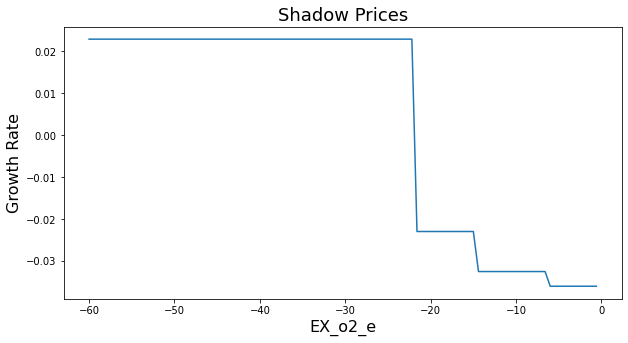

In [6]:
npts = 100 # Number of points to plot
metab = 'o2_e' # Metabolite to show shadow prices
reac = 'EX_o2_e'
l_bound = -60 # Range of the plot
u_bound = 0
SP = []
reaction_lb = []
increment = (u_bound - l_bound)/npts
model.reactions.get_by_id(reac).lower_bound = l_bound # Set initial conditions
model.reactions.get_by_id(reac).upper_bound = l_bound # Set initial conditions
for i in range(npts):
    SP.append(model.optimize().shadow_prices[metab])
    reaction_lb.append(model.reactions.get_by_id(reac).lower_bound)
    model.reactions.get_by_id(reac).upper_bound += increment
    model.reactions.get_by_id(reac).lower_bound += increment

plt.figure(figsize = (10, 5))
plt.plot(reaction_lb,SP)
plt.xlabel('EX_o2_e',size = 16)
plt.ylabel('Growth Rate',size = 16)
plt.title('Shadow Prices',size = 18)
plt.show()

Plot the shadow prices for glucose over a range of -60 to 0 mmol/(gDW hr) assuming oxygen is at -20 mmol/(gDW hr)

C:\Users\hinton\.conda\envs\Combined\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


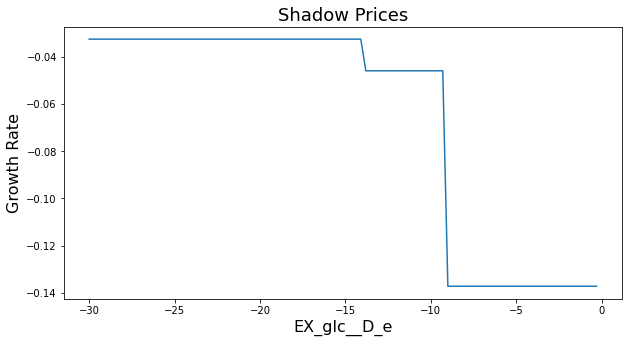

In [7]:
model2 = model_orig.copy()
model2.reactions.EX_o2_e.bounds = [-20,-20]
npts = 100 # Number of points to plot
metab = 'glc__D_e' # Metabolite to show shadow prices
reac = 'EX_glc__D_e'
l_bound = -30 # Range of the plot
u_bound = 0
SP2 = []
reaction_lb2 = []
increment = (u_bound - l_bound)/npts
model2.reactions.get_by_id(reac).lower_bound = l_bound # Set initial conditions
model2.reactions.get_by_id(reac).upper_bound = l_bound # Set initial conditions
for i in range(npts):
    SP2.append(model2.optimize().shadow_prices[metab])
    reaction_lb2.append(model2.reactions.get_by_id(reac).lower_bound)
    model2.reactions.get_by_id(reac).upper_bound += increment
    model2.reactions.get_by_id(reac).lower_bound += increment

plt.figure(figsize = (10, 5))    
plt.plot(reaction_lb2, SP2)
plt.xlabel('EX_glc__D_e',size = 16)
plt.ylabel('Growth Rate',size = 16)
plt.title('Shadow Prices',size = 18)
plt.show()

## Reduced Costs

Reduced costs are calculated with the model.optimize() method.

In [8]:
model = model_orig.copy()
model.reactions.EX_glc__D_e.lower_bound = -10
model.reactions.EX_o2_e.bounds = [-20,-20]
solution = model.optimize()
solution_frame = solution.to_frame()
solution_frame['reduced_costs'] = solution_frame['reduced_costs'].div(2) # Correct factor of two error
solution_frame.sort_index().round(5)

,fluxes,reduced_costs
ACALD,0.00000,0.00000
ACALDt,0.00000,-0.00000
ACKr,-1.80256,-0.00000
ACONTa,4.69464,0.00000
ACONTb,4.69464,0.00000
ACt2r,-1.80256,0.00000
ADK1,0.00000,-0.00000
AKGDH,3.79634,0.00000
AKGt2r,0.00000,0.00000
ALCD2x,0.00000,-0.00000


Below are a set of reactions that will increase the growth rate if thier flux is increased.

In [9]:
solution_RCincrease = solution_frame[solution_frame['reduced_costs'] <= -0.000001]
solution_RCincrease = solution_RCincrease.sort_values(by='reduced_costs')
solution_RCincrease = solution_RCincrease.reset_index(drop=False)
solution_RCincrease

,index,fluxes,reduced_costs
0,EX_fru_e,0.00,-0.045911
1,EX_glc__D_e,-10.00,-0.045911
2,EX_gln__L_e,0.00,-0.036984
3,EX_glu__L_e,0.00,-0.034433
4,EX_akg_e,0.00,-0.030607
5,EX_mal__L_e,0.00,-0.022955
6,EX_fum_e,0.00,-0.022955
7,EX_o2_e,-20.00,-0.022955
8,EX_succ_e,0.00,-0.016579
9,EX_lac__D_e,0.00,-0.012753


Looking at a plot of the reduced cost of oxygen first

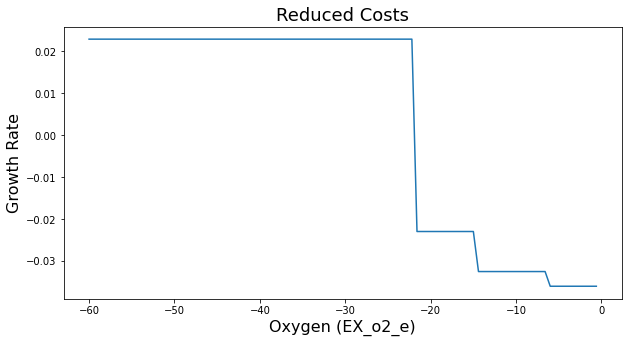

In [10]:
model3 = model_orig.copy()
model3.reactions.EX_glc__D_e.bounds = [-10,-10]
npts = 100 # Number of points to plot
reac = 'EX_o2_e' # Reaction to calculate reduced costs
l_bound = -60 # Range of the plot
u_bound = 0
RC3 = []
reaction_lb3 = []
increment = (u_bound - l_bound)/npts
model3.reactions.get_by_id(reac).lower_bound = l_bound # Set initial conditions
model3.reactions.get_by_id(reac).upper_bound = l_bound # Set initial conditions
for i in range(npts):
    RC3.append(model3.optimize().reduced_costs[reac]/2) # Fix reduced costs factor of two problem
    reaction_lb3.append(model3.reactions.get_by_id(reac).lower_bound)
    model3.reactions.get_by_id(reac).upper_bound += increment
    model3.reactions.get_by_id(reac).lower_bound += increment

plt.figure(figsize = (10, 5))      
plt.plot(reaction_lb3, RC3)
plt.xlabel('Oxygen (EX_o2_e)',size = 16)
plt.ylabel('Growth Rate',size = 16)
plt.title('Reduced Costs',size = 18)
plt.show()

Plotting the reduced cost of glucose

C:\Users\hinton\.conda\envs\Combined\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


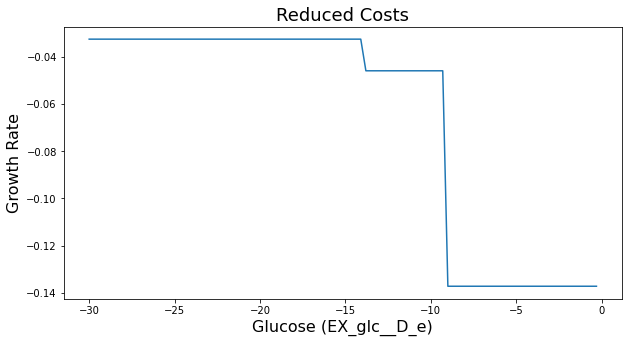

In [11]:
model4 = model_orig.copy()
model4.reactions.EX_o2_e.bounds = [-20,-20]
npts = 100 # Number of points to plot
reac = 'EX_glc__D_e' # Reaction to calculate reduced costs
l_bound = -30 # Range of the plot
u_bound = 0
SP4 = []
reaction_lb4 = []
increment = (u_bound - l_bound)/npts
model4.reactions.get_by_id(reac).lower_bound = l_bound # Set initial conditions
model4.reactions.get_by_id(reac).upper_bound = l_bound # Set initial conditions
for i in range(npts):
    SP4.append(model4.optimize().reduced_costs[reac]/2)  # Fix reduced costs factor of two problem
    reaction_lb4.append(model4.reactions.get_by_id(reac).lower_bound)
    model4.reactions.get_by_id(reac).upper_bound += increment
    model4.reactions.get_by_id(reac).lower_bound += increment
plt.figure(figsize = (10, 5))
plt.plot(reaction_lb4, SP4)
plt.xlabel('Glucose (EX_glc__D_e)',size = 16)
plt.ylabel('Growth Rate',size = 16)
plt.title('Reduced Costs',size = 18)
plt.show()